In [1]:
using CSV
using JuMP, Ipopt
using MosekTools 
using Gurobi
using DataFrames #, IndexedTables
using CSV
using LinearAlgebra
using Plots#, PlotlyJS
using Statistics
using Plots

In [48]:
df = DataFrame(CSV.File("baseline_all.csv"));
# Filter out rows where the state is 'DC'
df = filter(row -> row.state != "DC", df)
first(df, 2)

Row,Column1,year,amt,cma,sma,p_cma,p_sma,balance_cma,balance_sma,state
,Int64,Int64,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,String
1,0,1975,17954.0,17954.0,missing,missing,missing,missing,missing,MD
2,1,1976,0.0,8977.0,missing,17954.0,missing,0.0,missing,MD


In [49]:
#number of states
N = length(unique(df.state)); 
#number of years 
T = length(unique(df.year)); 

state_list = unique(df.state);
time_list = unique(df.year);
println(state_list[4])
println(length(state_list))
println(N)

FL
52
52


In [50]:
#amount matrix
M_amt = Matrix{Float64}(undef,N,T); 

#construct M_amt: where i, t = loss at state i in time t 
i=1
for state in state_list
    M_amt[i,:] = df[df.state .== state, "amt"] 
    i+=1 
end 

In [51]:
#construct premium baseline 
#baseline premium for final 10 years 
P_base = Matrix{Float64}(undef,N,10); 

#construct P_base: where i, t = premium using CMA at state i in time t 
i=1
for state in state_list
    P_base[i,:] = df[df.state .== state, "p_cma"][end-9:end] #final 10 years of premium 
    i+=1 
end 

In [52]:
size(M_amt)
act_loss = M_amt[:,end-9:end]; 

In [160]:
#construct P_hist: actual policies
#load actual policy premiums 
df_policy = DataFrame(CSV.File("nfip_premium_agg.csv"));
#policy data is from 2010-2022 
year_list = range(2013, 2022)
#amount matrix
P_hist= Matrix{Float32}(undef,N,length(year_list)); 

i =1
for state in state_list
    t = 1 
    for year in year_list 
        premium = df_policy[(df_policy.propertyState .== state ).& (df_policy.year .== year) , "sum"]
        if length(premium)==1
            P_hist[i,t] = premium[1]
        else 
            println(state, year, "missing")
            P_hist[i, t] = 0  
        end 
        t+=1 
    end 
    i+=1 
end 

SD2013missing
VI2013missing
WY2021missing


In [163]:
#
#compute the historical mean and variance up to 10 years  
M_hist = M_amt[:, 1:end-10]; 
std_hist = std(M_hist, dims=2); #std_hist[i,t] = state i at year t 
mean_hist = mean(M_hist, dims=2); 

### RO approach 1: no demand damping 

#
gamma2 = 1 

#compute $L^*_i$ for each i, where
$
L^* := \sum_{t=T0}^{t=T1} l^*_{i,t}
$\
where 
$
\sum_{t=T0}^{t=T1} l^*_{i,t} = \bar{l}_i (T1-T0) + \gamma_2 \sigma_i \sqrt(T1-T0) 
$

In [164]:
#try different gammas 
gamma2 = 0.8

function solve_ro(gamma2)
    
        #gamma determines L_star
        L_star = 10*mean_hist + gamma2*std_hist*sqrt(10); 

        model3 = Model(Gurobi.Optimizer)
        set_optimizer_attribute(model3, "TimeLimit", 30)

        # VARIABLES: premium for the next 10 years 
        T1 = 10 
        @variable(model3, P[1:N,1:T1] >=0);  #P_i,t is the premium at state i in time t 
        @variable(model3, surplus>= 1000) 
    
        # each state premium covers state loss L* from the inner problem 
        @constraint(model3, test_constraint[i=1:N],
            sum(P[i, t] for t = 1:T1) - L_star[i] >= surplus); 

        #slowly vary 
        gamma1 = 50000  
        @constraint(model3, slowly_vary[i=1:N, t=2:T1],
            P[i,t] - P[i, t-1] <= gamma1);
        @constraint(model3, slowly_vary2[i=1:N, t=2:T1],
            P[i,t-1] - P[i, t] <= gamma1)

        @objective(
                model3, Min, sum(P[i, t] for t = 1:T1, i = 1:N) 
            )

        optimize!(model3)
        P_ro = value.(P);   
    return P_ro 
end 

solve_ro (generic function with 1 method)

### RO Approach 2 + demand decline 

In [165]:
#piece-wise linear 
#l_max is the largest historical flood amount overall states overall years 
l_max = maximum(M_hist)
#rate is 1/l_max 
println("l_max= ", l_max)
println("mean P hist", median(P_hist))
println("max P hist", maximum(P_hist))

function f_piecewise_linear(p, slope = 1/maximum(P_hist) , p_begin = maximum(P_hist)/10, floor = 0.2) #default rate is 1/P_max # floor is the minimum 
    if p < p_begin 
        f = 1.00
    else 
        f = 1 - slope*(p-p_begin) 
        # f needs to be greater than 0 
         if f < floor 
#             print("negative f_p") 
            f = floor  
        end 
    end 
    return f
end 

# plot(f_piecewise_linear, 0, maximum(P_hist)*2, xlabel="premium", ylabel="demand as % of 100%", ylims=(0, 1))
# Setting y-axis limits
# plt.ylim(0, 1)
# plot(f_piecewise_linear(slope= 1/maximum(M_amt)), 0, maximum(M_amt))
# savefig("figs/demand_curve.png")

l_max= 1.079988857742e10
mean P hist52508.5
max P hist4.585367e6


f_piecewise_linear (generic function with 4 methods)

In [166]:
#try different gammas 
# P_lim = l_max #historical max 

function solve_ro2(gamma2, demand_slope=1/maximum(P_hist))   
    P_lim = maximum(P_hist) #historical max 

    
    #gamma determines L_star
    L_star = 10*mean_hist + gamma2*std_hist*sqrt(10); 
    println("L_star", maximum(L_star))

    #         model3 = Model(Gurobi.Optimizer)
    model3 = Model(Ipopt.Optimizer)
    register(model3, :f_piecewise_linear, 2, f_piecewise_linear; autodiff = true)
    #         model3 = Model(Mosek.Optimizer)
    set_attribute(model3, "max_cpu_time", 60.0)
    #         set_optimizer_attribute(model3, "TimeLimit", 30)
#     register(model3, :f_linear, 2, f_linear; autodiff = true)

    # VARIABLES: premium for the next 10 years 
    T1 = 10 
    @variable(model3, P[1:N,1:T1] >=0);  #P_i,t is the premium at state i in time t 
#     @constraint(model3, set_limit[i=1:N, t=1:T1], P[i,t] <= 1/demand_slope) #set upper limit such that f(p) is not negative 
    
    
    # each state premium covers state loss L* from the inner problem 
    # adding demand term to demp the revenue: reduce demand by f(P), reduce loss by avg of f(P) across time 
    @variable(model3, surplus>= 1000 ) 
    
#     @NLconstraint(model3, coverage[i=1:N],
#         sum(P[i, t]* f_linear(P[i,t], demand_slope) for t = 1:T1) - L_star[i]*1/T1*sum(f_linear(P[i,t], demand_slope) for t = 1:T1) >= surplus); 
    
#     #I changed this constraint to have L_star inside, each year is the average of L_star 
#     @NLconstraint(model3, coverage[i=1:N],
#         sum(P[i, t]* f_linear(P[i,t], demand_slope) for t = 1:T1) - sum(L_star[i]*1/T1 * f_linear(P[i,t], demand_slope) for t = 1:T1) >= surplus); 

    #I changed this constraint to have L_star inside, each year is the average of L_star 
    @NLconstraint(model3, coverage[i=1:N],
        sum(P[i, t]* f_piecewise_linear(P[i,t], demand_slope) for t = 1:T1) - sum(L_star[i]*1/T1 * f_piecewise_linear(P[i,t], demand_slope) for t = 1:T1) >= surplus); 



    #slowly vary 
    gamma1 = 50000  
    @constraint(model3, slowly_vary[i=1:N, t=2:T1],
        P[i,t] - P[i, t-1] <= gamma1);
    @constraint(model3, slowly_vary2[i=1:N, t=2:T1],
        P[i,t-1] - P[i, t] <= gamma1)

    @objective(
            model3, Min, surplus 
        )

    optimize!(model3)
    P_ro = value.(P);  
    return P_ro 
end 


solve_ro2 (generic function with 2 methods)

### RO Approach 3: Adding ML Predictions 

In [167]:
#read in data from ML models 
df_ml_99_5 = DataFrame(CSV.File("ml_base_0.99_5.csv"));
df_ml_99_10 = DataFrame(CSV.File("ml_base_0.99_10.csv"));

df_ml_90_5 = DataFrame(CSV.File("ml_base_0.9_5.csv"));
df_ml_90_10 = DataFrame(CSV.File("ml_base_0.9_10.csv"));

amt_99 = 321903271.0
amt_90 = 18558788.0

first(df_ml_99_5, 2)

Row,Column1,state,year,predict_proba,actual
,Int64,String,Int64,Float64,Int64
1,37,MT,2012,0.000241107,0
2,38,MT,2013,0.000215973,0


In [168]:
#get the year list for the last 10 years 
# time_list[end-9:end]

In [169]:
#suppose we are at 2013 

#construct the ML risk matrix for all the states 
#risk matrix has size n_state by 4 risk scenarios 
M_risk = Array{Float64}(undef, N, 4); 
j=1 
#loop over different risks 
for df_ml in [df_ml_99_5, df_ml_99_10, df_ml_90_5, df_ml_90_10]
    #loop over states 
    i=1
    for state in state_list
        risk = df_ml[(df_ml.state .== state ).& ( df_ml.year .== 2013),"predict_proba"]
        #if the risk of the state exists
        if length(risk)==1
            M_risk[i,j] =  risk[1]
        else 
            M_risk[i,j] = 0 
        end 
        i+=1 
    end  
    j+=1 
end 

#DC is missing, but I should probably take out DC  
M_risk

52×4 Matrix{Float64}:
 0.0111471    0.0111471    0.945705   0.945705
 0.000215973  0.000215973  0.334499   0.334499
 0.803008     0.803008     0.986872   0.986872
 0.837126     0.837126     0.987006   0.987006
 0.000936527  0.000936527  0.861768   0.861768
 0.250503     0.250503     0.955619   0.955619
 0.00105916   0.00105916   0.673502   0.673502
 0.0586109    0.0586109    0.979024   0.979024
 0.68627      0.68627      0.983587   0.983587
 0.0122663    0.0122663    0.965099   0.965099
 0.0489217    0.0489217    0.960257   0.960257
 0.912395     0.912395     0.993227   0.993227
 0.0310645    0.0310645    0.948335   0.948335
 ⋮                                    
 0.00266153   0.00266153   0.942064   0.942064
 0.00024211   0.00024211   0.89457    0.89457
 0.000477915  0.000477915  0.446341   0.446341
 0.000477915  0.000477915  0.262573   0.262573
 0.00018991   0.00018991   0.411833   0.411833
 0.00016241   0.00016241   0.237991   0.237991
 0.000604816  0.000604816  0.5765     0.5765
 0

In [170]:
# try optimization model with damping as well 
function solve_ro3(gamma2, demand_slope=1/maximum(P_hist))   

    #gamma determines L_star
    L_star = 10*mean_hist + gamma2*std_hist*sqrt(10); 
    println("L_star", maximum(L_star))

    model4 = Model(Ipopt.Optimizer)
    register(model4, :f_piecewise_linear, 2, f_piecewise_linear; autodiff = true)
    set_attribute(model4, "max_cpu_time", 300.0)

    # VARIABLES: premium for the next 10 years 
    T1 = 10 
    @variable(model4, P[1:N,1:T1] >=0);  #P_i,t is the premium at state i in time t 
    #     @constraint(model4, set_limit[i=1:N, t=1:T1], P[i,t] <= 1/demand_slope) #set upper limit such that f(p) is not negative 


    # each state premium covers state loss L* from the inner problem 
    # adding demand term to demp the revenue: reduce demand by f(P), reduce loss by avg of f(P) across time 
    @variable(model4, surplus>=1000 ) 

    # @NLconstraint(model4, coverage[i=1:N],
    #     sum(P[i, t]* f_linear(P[i,t], demand_slope) for t = 1:T1) - L_star[i]*1/T1*sum(f_linear(P[i,t], demand_slope) for t = 1:T1) >= surplus); 
    # #I changed this constraint to have L_star inside, each year is the average of L_star 
    @NLconstraint(model4, coverage[i=1:N],
        sum(P[i, t]* f_piecewise_linear(P[i,t], demand_slope) for t = 1:T1) - sum(L_star[i]*1/T1 * f_piecewise_linear(P[i,t], demand_slope) for t = 1:T1) >= surplus); 
   
    #slowly vary 
    gamma1 = 50000  
    @constraint(model4, slowly_vary[i=1:N, t=2:T1],
        P[i,t] - P[i, t-1] <= gamma1);
    @constraint(model4, slowly_vary2[i=1:N, t=2:T1],
        P[i,t-1] - P[i, t] <= gamma1)

    #adding risk constraint from ML, for 99% risk for 5, 10 years respectively 
#     @constraint(model4, ml_risk_99_5[i=1:N],
#         sum(P[i,t] for t=1:5) >= amt_99*M_risk[i,1]
#     )
    @constraint(model4, ml_risk_99_10[i=1:N],
        sum(P[i,t] for t=1:10) >= amt_99*M_risk[i,2]
    )
#     @constraint(model4, ml_risk_90_5[i=1:N],
#         sum(P[i,t] for t=1:5) >= amt_90*M_risk[i,3]
#     )
    @constraint(model4, ml_risk_90_10[i=1:N],
        sum(P[i,t] for t=1:10) >= amt_90*M_risk[i,4]
    )

    @objective(
            model4, Min, surplus 
        )

    optimize!(model4)
    P_ml = value.(P); 
    return P_ml 
end 



solve_ro3 (generic function with 2 methods)

In [171]:
#BUG: I'm here, it's strange RO3 should be greater than RO2, the problem seems to be due to I took away DC state
#But why?? So strange! 
# RO2 = solve_ro2(gamma2) 
RO3 = solve_ro3(gamma2) 

L_star7.808811639581051e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3484
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1092
        inequality constraints with only lower bounds:      156
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 7.81e+09 1.42e+00   0.0 0.00e+00

52×10 Matrix{Float64}:
      1.14636e7  1.14636e7  1.14636e7  …       1.14636e7  1.14636e7
      5.83492e5  5.87008e5  5.94124e5          6.6106e5   6.65162e5
      1.869e8    1.869e8    1.869e8            1.86899e8  1.86899e8
      1.24259e8  1.24259e8  1.24259e8          1.24259e8  1.24259e8
      2.27733e7  2.27733e7  2.27732e7          2.27729e7  2.27728e7
      2.20621e7  2.20621e7  2.20621e7  …       2.20621e7  2.20621e7
      1.38415e6  1.38431e6  1.38461e6          1.38724e6  1.3874e6
      3.35052e7  3.35052e7  3.35052e7          3.35052e7  3.35052e7
      2.81882e8  2.81882e8  2.81882e8          2.81882e8  2.81882e8
      7.9113e6   7.9113e6   7.9113e6           7.91129e6  7.91129e6
      1.27507e7  1.27507e7  1.27507e7  …       1.27507e7  1.27507e7
      7.80881e8  7.80881e8  7.80881e8          7.80882e8  7.80882e8
      1.85822e7  1.85822e7  1.85822e7          1.85822e7  1.85822e7
      ⋮                                ⋱                  
      1.11684e7  1.11684e7  1.11684

In [123]:
# RO3-RO2

### ARO Approach


In [124]:
#attempt 2 of solving ARO: slowly vary alpha instead of P
# so that beta cannot all be 0 
i=3 
gamma2 = 0.8

function solve_aro(i, gamma2)
gamma1 = 5e4  
T= 10 
delta = 1e5 #this is surplus 

#for now let's solve it for one state i 
c1 =  T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T) #c1 is a vector, where c1[i] is the ith state value 
c2 = -T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T)
println(c1, c2)


#try decompose into small models 
println(c1, c2)
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "TimeLimit", 300)


# VARIABLES: premium for the next 10 years 
@variable(model, alpha[1:T]);  #P_i,t is the premium at state i in time t 
@variable(model, beta[1:(T-1)]);

@variable(model, omega); 

#simplifying: forcing all alpha to be the same 
# for t=2:T
# @constraint(model, alpha[t] == alpha[1]); 
# end 

# (1) Epigraph formulation of the objective value 
@objective(model, Min, omega)

@variable(model, s11>=0);
@variable(model, s12>=0);

@constraint(model, epigraph, 
    sum(alpha[t] for t = 1:T) + (c1*s11+c2*s12)  <= omega ); 

for t=1:(T-1)
    @constraint(model, 
        s11-s12 >= beta[t]);  
end 

@constraint(model, s11 - s12 >=0); 

# (2) surplus constraint 
@variable(model, s21>=0);
@variable(model, s22>=0);

@constraint(model, surplus, 
    -sum(alpha[t] for t = 1:T) + (c1*s21+c2*s22)  <= -delta); 

for t=1:(T-1) 
    @constraint(model, 
        s21-s22 >= 1-beta[t]);  
end 
# @constraint(model, 
#         s21-s22 >= 1); # this is creating problem, double check this, related to obj function T or T-1  
    


# # surplus constraint 2 
# TT= 5
# @variable(model, ss21>=0);
# @variable(model, ss22>=0);

# @constraint(model, 
#     -sum(alpha[t] for t = 1:TT) + (c1*ss21+c2*ss22)  <= -delta); 

# for t=1:(TT-1) 
#     @constraint(model, 
#         ss21-ss22 >= 1-(TT-t)*beta[t]);  
# end 
# @constraint(model, 
#         ss21-ss22 >= 1);    
    
# surplus constraint, for all T' in T_list : this is not working 
# T_list = [5, 10]
# global T_list 
# T_size = length(T_list)
# @variable(model, s21[1:T_size]>=0);
# @variable(model, s22[1:T_size]>=0);

# for j = 1:T_size 
#     TT = T_list[j]
#     @constraint(model,
#         -sum(alpha[t] for t = 1:TT) + (c1*s21[j]+c2*s22[j])  <= -delta );  

#     for tt=1:(TT-1)
#         @constraint(model, 
#             s21[j]-s22[j] >= 1-(TT-tt)*beta[tt]);  
#     end 
# #     @constraint(model, s21[j] - s22[j] >=1); 
#     @constraint(model, s21[j] - s22[j] >=0); 
# end 

# (3) slowly varying constraints: on alpha 
for t=2:T
    @constraint(model, 
        alpha[t] - alpha[t-1] <= gamma1 ) 
    @constraint(model, 
        alpha[t] - alpha[t-1] >= -gamma1)
end    

# (4) positive l_i constraint 
@variable(model, s51[2:T] >=0)
@variable(model, s52[2:T] >=0)

for t=2:T
    @constraint(model, 
        -alpha[t] + (c1*s51[t]+c2*s52[t]) <= 0 ) 
    for tao = 1:(t-1)
        @constraint(model, s51[t] - s52[t] >= -beta[tao])
        @constraint(model, s51[t] - s52[t] >= 0)
    end 
end 

@constraint(model, alpha[1]>=0)
@constraint(model, alpha[1] == mean_hist[i]) #force alpha 1 = historical alpha 
# for t = 1:T
#     @constraint(model, alpha[t] == mean_hist[i])
# end 

optimize!(model)
    # println(termination_status(model))
    # alpha = value.(alpha)
    # beta = value.(beta)
    # print(alpha, beta)
    println(value.(s21), value.(s22))
    
    return value.(alpha), value.(beta)
end 


solve_aro (generic function with 1 method)

In [125]:
#new recover P, for solve_aro3, i.e., P = alpha_it + beta_it*l_it-1
function recover_P(i, alpha, beta)
    act_loss = M_amt[:,end-9:end];  
    T1 = 10 
    P_i = Matrix{Float64}(undef,1,T1); 
    P_i[1] = alpha[1]
    for t=2:T1
        P_i[t] = alpha[t] + beta[t-1] * act_loss[i, t-1] 
    end 
    return P_i 
end 

recover_P (generic function with 1 method)

In [126]:
#wrap into a function 
function get_P_aro(gamma2)
    N =  length(state_list) 
    T1 = 10 
    P_aro = Matrix{Float64}(undef,N,T1); 
    Beta = Matrix{Float64}(undef,N,T1-1);  
    Alpha = Matrix{Float64}(undef,N,T1);   
    for i=1:N 
        alpha_i, beta_i = solve_aro(i, gamma2); 
        Beta[i,:] = beta_i; 
        Alpha[i,:] = alpha_i; 
        P_aro[i,:] = recover_P(i, alpha_i, beta_i); 
    end 
return P_aro 
end 

get_P_aro (generic function with 1 method)

### Compare Results

#### 1: Compare RO1 vs. RO2: evaluate demand damping effects 

In [127]:
# #iterate over different demand damping slopes 
# gamma2 = 0.8 
# multiple_ls = range(start=1, step =0.2, stop=3) 
# #record different surplus associated with different slopes in a dictionary 
# surplus_ls = Array{Float64}(undef,length(multiple_ls));

# j =1 
# for multiple in multiple_ls
#     slope = 1/(maximum(P_hist)*multiple)
#     println("slope" , slope)
#     P_ro = solve_ro3(gamma2, slope); 
#     s = sum(P_ro)-sum(act_loss)
#     surplus_ls[j] = s 
#     j+=1 
# end 


In [128]:
# slope = 1/maximum(P_hist)

# P_ro3 = solve_ro3(0.8, slope)

#### 2: Compare RO2 vs. RO3: evaluate ML effects 

In [129]:
#parameters: 
gamma2 = 0.8 
slope = 1/maximum(P_hist)

#call solve RO 
P_ro1 = solve_ro(gamma2) #1/l_max 
P_ro2 = solve_ro2(gamma2, slope)
P_ro3 = solve_ro3(gamma2, slope)

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 988 rows, 521 columns and 2444 nonzeros
Model fingerprint: 0x236c2017
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+03, 1e+03]
  RHS range        [5e+04, 8e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 468 rows and 1 columns
Presolve time: 0.00s
Presolved: 520 rows, 988 columns, 1924 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.171453e+10   0.000000e+00      0s
     516    2.1714525e+10   0.000000e+00   0.000000e+00      0s

Solved in 516 iterations and 0.01 seconds
Optimal objective  2.171452519e+10

User-callback calls 547, time in user-callback 0.00 sec
L_st

L_star7.808811639581051e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3484
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1092
        inequality constraints with only lower bounds:      156
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 7.81e+09 1.42e+00   0.0 0.00e+00

52×10 Matrix{Float64}:
 1.14641e7  1.14641e7  1.14641e7  …  1.14641e7  1.14641e7  1.14641e7
 6.23543e5  6.23544e5  6.23545e5     6.23558e5  6.2356e5   6.23561e5
 1.869e8    1.869e8    1.869e8       1.869e8    1.869e8    1.869e8
 1.24259e8  1.24259e8  1.24259e8     1.24259e8  1.24259e8  1.24259e8
 2.27735e7  2.27735e7  2.27735e7     2.27735e7  2.27735e7  2.27735e7
 2.20626e7  2.20626e7  2.20626e7  …  2.20626e7  2.20626e7  2.20626e7
 1.38583e6  1.38583e6  1.38583e6     1.38583e6  1.38583e6  1.38583e6
 3.35057e7  3.35057e7  3.35057e7     3.35057e7  3.35057e7  3.35057e7
 2.81881e8  2.81881e8  2.81881e8     2.81881e8  2.81881e8  2.81881e8
 7.91187e6  7.91187e6  7.91187e6     7.91187e6  7.91187e6  7.91187e6
 1.27512e7  1.27512e7  1.27512e7  …  1.27512e7  1.27512e7  1.27512e7
 7.80882e8  7.80882e8  7.80882e8     7.80882e8  7.80882e8  7.80882e8
 1.85827e7  1.85827e7  1.85827e7     1.85827e7  1.85827e7  1.85827e7
 ⋮                                ⋱                        
 1.1169e7   1.1169e7  

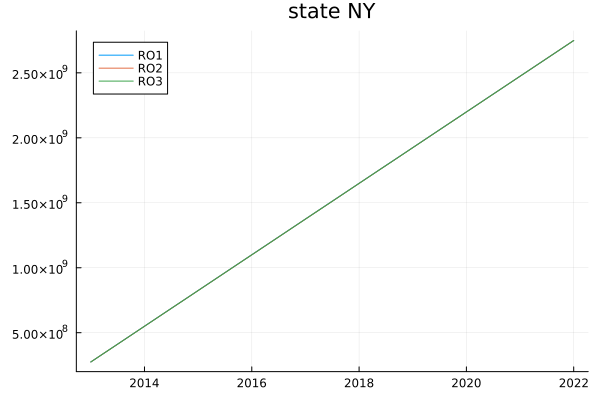

In [130]:
x = time_list[end-9:end] 
i = 17 # is 12, NY is 17, FL is 4  

#crop P_hist to the last 10 years only 
P_hist2 = P_hist[:, end-9:end]

act = cumsum(act_loss[i,:])
base = cumsum(P_base[i,:])
hist = cumsum(P_hist2[i,:])

RO1= cumsum(P_ro1[i,:])
RO2= cumsum(P_ro2[i,:])
RO3 = cumsum(P_ro3[i,:])
# plot(x, [act, base, hist, RO1, RO2, RO3], 
#     label=["actual loss" "cma" "hist" "RO1" "RO2" "RO3"], title="state $(state_list[i])")

plot(x, [ RO1, RO2, RO3], 
    label=[ "RO1" "RO2" "RO3"], title="state $(state_list[i])")

#### 2: Compare RO3 vs. RO4: evaluate ARO effects

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 988 rows, 521 columns and 2444 nonzeros
Model fingerprint: 0x236c2017
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+03, 1e+03]
  RHS range        [5e+04, 8e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 468 rows and 1 columns
Presolve time: 0.00s
Presolved: 520 rows, 988 columns, 1924 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.171453e+10   0.000000e+00      0s
     516    2.1714525e+10   0.000000e+00   0.000000e+00      0s

Solved in 516 iterations and 0.00 seconds
Optimal objective  2.171452519e+10

User-callback calls 547, time in user-callback 0.00 sec
L_st

In iteL_star7.808811639581051e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4004
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1196
        inequality constraints with only lower bounds:      260
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 7.81e+09 1.45e+00   0.0 0.

52×10 Matrix{Float64}:
 92289.4  92289.4  92289.4  92289.4  …  55374.8  55374.8  55374.8  55374.8
 55386.1  55386.1  55386.1  55386.1     36917.3  36917.3  36917.3  36917.3
 92289.4  92289.4  92289.4  92289.4     55374.8  55374.8  55374.8  55374.8
 92289.4  92289.4  92289.4  92289.4     55374.8  55374.8  55374.8  55374.8
 60294.3  60294.3  60294.3  60294.3     37114.5  37114.5  37114.5  37114.5
 92289.4  92289.4  92289.4  92289.4  …  55374.8  55374.8  55374.8  55374.8
 68189.3  68189.3  68189.3  68189.3     35653.7  35653.7  35653.7  35653.7
 92289.4  92289.4  92289.4  92289.4     55374.8  55374.8  55374.8  55374.8
 92289.4  92289.4  92289.4  92289.4     55374.8  55374.8  55374.8  55374.8
 92289.4  92289.4  92289.4  92289.4     55374.8  55374.8  55374.8  55374.8
 92289.4  92289.4  92289.4  92289.4  …  55374.8  55374.8  55374.8  55374.8
 92289.4  92289.4  92289.4  92289.4     55374.8  55374.8  55374.8  55374.8
 92289.4  92289.4  92289.4  92289.4     55374.8  55374.8  55374.8  55374.8
  

In [38]:
x = time_list[end-9:end] 
i = 17 # is 12, NY is 17, FL is 4  
println(state_list[i])
println(Alpha[i,:])
println(Beta[i,:])
println(P_aro[i,:])

#crop P_hist to the last 10 years only 
P_hist2 = P_hist[:, end-9:end]

act = cumsum(act_loss[i,:])
base = cumsum(P_base[i,:])
hist = cumsum(P_hist2[i,:])

RO1= cumsum(P_ro1[i,:])
RO2= cumsum(P_ro2[i,:])
RO3 = cumsum(P_ro3[i,:])
ARO = cumsum(P_aro[i,:])
plot(x, [act, base, hist, RO3, aro], 
    label=["actual loss" "cma" "hist" "RO3" "ARO"], title="state $(state_list[i])")

# savefig("figs/0.8gamma_$(state_list[i]).png")

NY


LoadError: UndefVarError: Alpha not defined

### Evaluations: 
- insolvency
- absolute deviation
- surplus and deficit 

In [131]:
#how to compare insolvency: 
#function to coun the insolvency states at the end of testing period 
function count_insolvency(P, actual)
    x = sum(P, dims=2) - sum(actual, dims=2)
    neg_ct = count(x -> x < 0, x)
    return neg_ct 
end 

#overall surplus/deficit 
function surplus(P, act)
    surplus = sum(P, dims =2) - sum(act, dims=2)
    return sum(surplus) #return total sum of surplus  
end 

# surplus(P_aro, act_loss)
#absolute deviation from true losses 
function abs_deviation(P, act)
    abs_states = sum(abs.(P - act), dims=2) #by states 
    abs_total = sum(abs_states) #total absolute deviation 
    return abs_states, abs_total 
end 

abs_deviation (generic function with 1 method)

In [178]:
# Define the range of gamma2 parameters
params = range(0, stop=2, step=0.2)

N = length(state_list)
T = 10 
slope = 1/maximum(P_hist)

# Assuming N and T are defined earlier in your code
# Initialize matrices to store results for each gamma2
# Each matrix will have a third dimension to accommodate different gamma2 values
ARO = Array{Float64, 3}(undef, length(params), N, T)
RO1 = Array{Float64, 3}(undef, length(params), N, T)
RO2 = Array{Float64, 3}(undef, length(params), N, T)
RO3 = Array{Float64, 3}(undef, length(params), N, T)

# Iterate over parameter values
for (i, param) in enumerate(params)
    # Assuming the following functions return an N x T matrix of results for the given param
    P_aro = get_P_aro(param)
    P_ro1 = solve_ro(param)
    P_ro2 = solve_ro2(param, slope)  #
    P_ro3 = solve_ro3(param, slope)  # 

    # Store the results in their respective matrices
    ARO[i, :, :] = P_aro
    RO1[i, :, :] = P_ro1
    RO2[i, :, :] = P_ro2
    RO3[i, :, :] = P_ro3
end

# Now ARO, RO1, RO2, and RO3 contain the results for all gamma2 values


5.6594639268421054e7-5.6594639268421054e7
5.6594639268421054e7-5.6594639268421054e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xc3231d96
Coefficient statistics:
  Matrix range     [1e+00, 6e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    5.6694639e+07   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  5.669463927e+07

User-callback calls 50, time in user-callback 0.00 sec
0.95847663258609630.0
2.33562449210

0.97406753455874150.0
8.40999835473684e7-8.40999835473684e7
8.40999835473684e7-8.40999835473684e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x97dce30f
Coefficient statistics:
  Matrix range     [1e+00, 8e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    8.4199984e+07   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  8.419998355e+07

User-callback calls 50, time in user-callback 0.00 sec
0.99346016518909040.0

0.99863840462525610.0
5.952242532578948e8-5.952242532578948e8
5.952242532578948e8-5.952242532578948e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xe2661609
Coefficient statistics:
  Matrix range     [1e+00, 6e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      11    5.9532425e+08   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.00 seconds


0.98997390861797780.0
5.27659675236842e7-5.27659675236842e7
5.27659675236842e7-5.27659675236842e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x8346e736
Coefficient statistics:
  Matrix range     [1e+00, 5e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+06]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    5.2865968e+07   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  5.286596752e+07

User-callback calls 50, time in user-callback 0.00 sec
0.99526209767900520.0

0.96162716200265220.0
7.596427628947368e6-7.596427628947368e6
7.596427628947368e6-7.596427628947368e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x8f66672b
Coefficient statistics:
  Matrix range     [1e+00, 8e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    7.6964276e+06   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  7.696427629e+06

User-callback calls 51, time in user-callback 0.00 sec
0.795956721276000

L_star3.391861401928947e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2444
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      988
        inequality constraints with only lower bounds:       52
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 3.39e+09 7.43e+00   0.0 0.00e+00

L_star3.391861401928947e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3484
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1092
        inequality constraints with only lower bounds:      156
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 3.39e+09 1.42e+00   0.0 0.00e+00

In7.109673856820215e7-4.2092539968639955e7
7.109673856820215e7-4.2092539968639955e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x2a8c5078
Coefficient statistics:
  Matrix range     [1e+00, 7e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1105996e+35   5.333145e+30   4.110600e+05      0s
      20    7.1196739e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  7.119673857e+07

User-callback calls 61, time in user-callback 0.00 sec
0.82626348903569070.0
2.79674765224

0.89236947945606340.0
9.494343889429079e7-7.325652820044602e7
9.494343889429079e7-7.325652820044602e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x24c73271
Coefficient statistics:
  Matrix range     [1e+00, 9e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1539578e+35   9.421008e+30   7.153958e+05      0s
      20    9.5043439e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  9.504343889e+07

User-callback calls 57, time in user-callback 0.00 sec
0.907382169328067

0.90731788463020660.0
7.926773650588373e8-3.977711414569522e8
7.926773650588373e8-3.977711414569522e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x25dcab2f
Coefficient statistics:
  Matrix range     [1e+00, 8e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      18    7.9277737e+08   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds


Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x123304fc
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9492567e+35   8.947947e+30   1.949257e+05      0s
      20    3.0009494e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  3.000949386e+07

User-callback calls 57, time in user-callback 0.00 sec
0.90556334439837660.0
5.971154001008665e7-4.582039503728176e7
5.971154001008665e7-4.582039503728176e7
Academic license 

0.85966145712255910.0
2.0144630622150544e7-1.3733499530481037e7
2.0144630622150544e7-1.3733499530481037e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x07207e1c
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3411621e+35   5.428821e+30   1.341162e+05      0s
      20    2.0244631e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  2.024463062e+07

User-callback calls 61, time in user-callback 0.00 sec
0.76889298031

0.00.0
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 988 rows, 521 columns and 2444 nonzeros
Model fingerprint: 0x48501c9d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+03, 1e+03]
  RHS range        [5e+04, 4e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 468 rows and 1 columns
Presolve time: 0.00s
Presolved: 520 rows, 988 columns, 1924 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.341121e+10   0.000000e+00      0s
     515    1.3411208e+10   0.000000e+00   0.000000e+00      0s

Solved in 515 iterations and 0.00 seconds
Optimal objective  1.341120787e+10

User-callback calls 546, time in user-callback 0.00 s

L_star4.496098961341972e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3484
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1092
        inequality constraints with only lower bounds:      156
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 4.50e+09 1.42e+00   0.0 0.00e+00

 723r 9.9999999e+02 4.50e+08.559883786798325e7-2.7590440668858863e7
8.559883786798325e7-2.7590440668858863e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x9ad774fe
Coefficient statistics:
  Matrix range     [1e+00, 9e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6943790e+35   5.225096e+30   2.694379e+05      0s
      21    8.5698838e+07   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  8.569883787e+07

User-callback calls 62, time in user-callback 0.00 sec
0.68043726

0.86024816788768340.0
1.0578689424121319e8-6.241307285352363e7
1.0578689424121319e8-6.241307285352363e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x92dadaa8
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      17    1.0588689e+08   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.00 second

0.81736627841859880.0
9.901304768597798e8-2.003180296560096e8
9.901304768597798e8-2.003180296560096e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x709b07f2
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      18    9.9023048e+08   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds


0.7620945391767820.0
6.665711249648909e7-3.8874822550879315e7
6.665711249648909e7-3.8874822550879315e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x2e57276b
Coefficient statistics:
  Matrix range     [1e+00, 7e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7963694e+35   8.510771e+30   3.796369e+05      0s
      19    6.6757112e+07   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 seconds
Optimal objective  6.675711250e+07

User-callback calls 56, time in user-callback 0.00 sec
0.75634790700451

0.62479411185069140.0
9.6173987934817e6-5.575456464413036e6
9.6173987934817e6-5.575456464413036e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x338f6126
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4447817e+34   5.351854e+30   5.444782e+04      0s
      21    9.7173988e+06   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  9.717398793e+06

User-callback calls 62, time in user-callback 0.00 sec
0.8678466816416360.0


L_star5.600336520754999e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2444
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      988
        inequality constraints with only lower bounds:       52
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 5.60e+09 7.43e+00   0.0 0.00e+00

L_star5.600336520754999e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3484
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1092
        inequality constraints with only lower bounds:      156
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 5.60e+09 1.42e+00   0.0 0.00e+00

 599r 9.9999999e+02 5.60e+09 2.74e+03  -2.2 2.73e+051.0010093716776434e8-1.3088341369077772e7
1.0010093716776434e8-1.3088341369077772e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x009aaf5d
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      19    1.0020094e+08   0.000000e+00   0.000000e+00      0s

Solved 

0.78271823321639070.0
1.1663034958813557e8-5.1569617506601244e7
1.1663034958813557e8-5.1569617506601244e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xb97361a5
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      18    1.1673035e+08   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seco

0.73371000004542520.0
1.1875835886607223e9-2.864917855067134e6
1.1875835886607223e9-2.864917855067134e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x2d667140
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      19    1.1876836e+09   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 second

0.76115324433421220.0
3.9858599005664915e7-1.0011283578545604e7
3.9858599005664915e7-1.0011283578545604e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x5b080949
Coefficient statistics:
  Matrix range     [1e+00, 4e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.7766441e+34   5.168711e+30   9.776644e+04      0s
      21    3.9958599e+07   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  3.995859901e+07

User-callback calls 62, time in user-callback 0.00 sec
0.66698132787

0.63708802862580140.0
2.655576171382005e7-7.322368438811529e6
2.655576171382005e7-7.322368438811529e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x2e0dffee
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1507504e+34   5.237755e+30   7.150750e+04      0s
      21    2.6655762e+07   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  2.665576171e+07

User-callback calls 62, time in user-callback 0.00 sec
0.700001200366312

0.143364396129638670.0
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 988 rows, 521 columns and 2444 nonzeros
Model fingerprint: 0x3a6b27a1
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+03, 1e+03]
  RHS range        [5e+04, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 468 rows and 1 columns
Presolve time: 0.00s
Presolved: 520 rows, 988 columns, 1924 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.894675e+10   0.000000e+00      0s
     516    1.8946753e+10   0.000000e+00   0.000000e+00      0s

Solved in 516 iterations and 0.00 seconds
Optimal objective  1.894675275e+10

User-callback calls 547, time in user

L_star6.704574080168024e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3484
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1092
        inequality constraints with only lower bounds:      156
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 6.70e+09 1.42e+00   0.0 0.00e+00

Excessive output truncated after 525086 bytes.


4.180117132666153e6-491131.8515443725
4.180117132666153e6-491131.8515443725

In [187]:
#display insolvency results 
results_is = Matrix{Float64}(undef, length(params), 7)

for (i, param) in enumerate(params)
    # Record insolvency
    results_is[i, 1] = param 
    results_is[i, 2] = count_insolvency(ARO[i,:,:], act_loss)
    results_is[i, 3] = count_insolvency(RO1[i,:,:], act_loss)  # Use RO1 results
    results_is[i, 4] = count_insolvency(RO2[i,:,:], act_loss)  # Use RO2 results
    results_is[i, 5] = count_insolvency(RO3[i,:,:], act_loss)  # Use RO3 results
#     # Assuming P_base and P_hist are defined elsewhere and their insolvency counts are still relevant
    results_is[i, 6] = count_insolvency(P_base, act_loss)  # Continue using P_base as before
    results_is[i, 7] = count_insolvency(P_hist, act_loss)  # Continue using P_hist as before
end


In [188]:
#display results of insolvency number 
df = DataFrame(results_is ,:auto)
names = [:gamma2, :ARO, :RO1, :RO2,:RO3, :CMA, :Hist]
rename!(df, names)

Row,gamma2,ARO,RO1,RO2,RO3,CMA,Hist
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,36.0,36.0,36.0,32.0,36.0,52.0
2,0.2,30.0,32.0,32.0,28.0,36.0,52.0
3,0.4,26.0,26.0,26.0,23.0,36.0,52.0
4,0.6,25.0,26.0,26.0,23.0,36.0,52.0
5,0.8,22.0,23.0,23.0,20.0,36.0,52.0
6,1.0,21.0,22.0,22.0,20.0,36.0,52.0
7,1.2,19.0,21.0,21.0,19.0,36.0,52.0
8,1.4,16.0,18.0,18.0,16.0,36.0,52.0
9,1.6,15.0,16.0,15.0,14.0,36.0,52.0


In [185]:
#next do surplus 
#display insolvency results 
results_is = Matrix{Float64}(undef, length(params), 7)

for (i, param) in enumerate(params)
    # Record surplus
    results_is[i, 1] = param 
    results_is[i, 2] = surplus(ARO[i,:,:], act_loss)  # Calculate surplus for ARO results
    results_is[i, 3] = surplus(RO1[i,:,:], act_loss)  # Calculate surplus for RO1 results
    results_is[i, 4] = surplus(RO2[i,:,:], act_loss)  # Calculate surplus for RO2 results
    results_is[i, 5] = surplus(RO3[i,:,:], act_loss)  # Calculate surplus for RO3 results
    # Assuming P_base and P_hist are defined elsewhere and their surplus calculations are still relevant
    results_is[i, 6] = surplus(P_base, act_loss)  # Calculate surplus for P_base
    results_is[i, 7] = surplus(P_hist, act_loss)  # Calculate surplus for P_hist
end

#display results of insolvency number 
df = DataFrame(results_is ,:auto)
names = [:gamma2, :ARO, :RO1, :RO2,:RO3, :CMA, :Hist]
rename!(df, names)

Row,gamma2,ARO,RO1,RO2,RO3,CMA,Hist
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,-9.23494e9,-9.267e9,-9.26677e9,-9.15535e9,-8.30512e9,-1.97797e10
2,0.2,-5.88108e9,-6.49922e9,-6.49776e9,-6.4114e9,-8.30512e9,-1.97797e10
3,0.4,-3.56483e9,-3.73145e9,-3.72971e9,-3.6657e9,-8.30512e9,-1.97797e10
4,0.6,-1.79644e9,-9.63678e8,-9.63497e8,-9.19263e8,-8.30512e9,-1.97797e10
5,0.8,-4.6499e8,1.80409e9,1.80439e9,1.83688e9,-8.30512e9,-1.97797e10
6,1.0,5.51929e8,4.57187e9,4.57459e9,4.60297e9,-8.30512e9,-1.97797e10
7,1.2,1.41115e9,7.33964e9,7.34002e9,7.36811e9,-8.30512e9,-1.97797e10
8,1.4,2.1583e9,1.01074e10,1.01078e10,1.0136e10,-8.30512e9,-1.97797e10
9,1.6,2.77912e9,1.28752e10,1.28922e10,1.28999e10,-8.30512e9,-1.97797e10


In [186]:
#display insolvency results 
results_is = Matrix{Float64}(undef, length(params), 7)

for (i, param) in enumerate(params)
    # Record absolute deviation
    results_is[i, 1] = param 
    _, results_is[i, 2] = abs_deviation(ARO[i,:,:], act_loss)  # Calculate absolute deviation for ARO results
    _, results_is[i, 3] = abs_deviation(RO1[i,:,:], act_loss)  # Calculate absolute deviation for RO1 results
    _, results_is[i, 4] = abs_deviation(RO2[i,:,:], act_loss)  # Calculate absolute deviation for RO2 results
    _, results_is[i, 5] = abs_deviation(RO3[i,:,:], act_loss)  # Calculate absolute deviation for RO3 results
    _, results_is[i, 6] = abs_deviation(P_base, act_loss)  # Calculate absolute deviation for P_base
    _, results_is[i, 7] = abs_deviation(P_hist, act_loss)  # Calculate absolute deviation for P_hist
end

#display results of insolvency number 
df = DataFrame(results_is ,:auto)
names = [:gamma2, :ARO, :RO1, :RO2,:RO3, :CMA, :Hist]
rename!(df, names)

Row,gamma2,ARO,RO1,RO2,RO3,CMA,Hist
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,2.25557e10,2.25385e10,2.25386e10,2.25842e10,2.30186e10,1.97908e10
2,0.2,2.47105e10,2.41781e10,2.41796e10,2.42219e10,2.30186e10,1.97908e10
3,0.4,2.64549e10,2.58922e10,2.58928e10,2.59284e10,2.30186e10,1.97908e10
4,0.6,2.77993e10,2.76834e10,2.76825e10,2.77076e10,2.30186e10,1.97908e10
5,0.8,2.8834e10,2.94929e10,2.94916e10,2.951e10,2.30186e10,1.97908e10
6,1.0,2.96e10,3.13097e10,3.13107e10,3.13267e10,2.30186e10,1.97908e10
7,1.2,3.02731e10,3.31906e10,3.319e10,3.32071e10,2.30186e10,1.97908e10
8,1.4,3.085e10,3.52573e10,3.52575e10,3.5274e10,2.30186e10,1.97908e10
9,1.6,3.13394e10,3.73975e10,3.741e10,3.74121e10,2.30186e10,1.97908e10


In [28]:
# # #compute this for different gamma2: 
# params = range(0, stop=2, step=0.2)
# # # Rows represent different parameters, columns represent different functions
# # results_is = Matrix{Float64}(undef, length(params), 5)
# # results_ad = Matrix{Float64}(undef, length(params), 5)
# # results_sd = Matrix{Float64}(undef, length(params), 5)



# RO1 = Matrix{Float64}(undef, length(params), N, T)


# # Iterate over parameter values
# for (i, param) in enumerate(params)
#     P_aro = get_P_aro(param); 
#     P_ro1 = solve_ro1(param); 
#     P_ro2 = solve_ro2(param, slope); 
#     P_ro3 = solve_ro3(param, slope); 

    
#     #record insolvency 
#     results_is[i, 1] = param 
#     results_is[i, 2] = count_insolvency(P_aro, act_loss)  # Call function1
#     results_is[i, 3] = count_insolvency(P_ro1, act_loss)  # Call function2
#     results_is[i, 3] = count_insolvency(P_ro2, act_loss)  # Call function2
#     results_is[i, 3] = count_insolvency(P_ro2, act_loss)  # Call function2
#     results_is[i, 4] = count_insolvency(P_base, act_loss)  #
#     results_is[i, 5] = count_insolvency(P_hist, act_loss) 

#     #record absolute deviation 
#     results_ad[i, 1] = param 
#     _, results_ad[i, 2] = abs_deviation(P_aro, act_loss)  # Call function1
#     _, results_ad[i, 3] = abs_deviation(P_ro, act_loss)  # Call function2
#     _, results_ad[i, 4] = abs_deviation(P_base, act_loss)  #
#     _, results_ad[i, 5] = abs_deviation(P_hist[:,end-9:end], act_loss) #P_hist has 53 by 13 dimension 
    
#     #record surplus deficit 
#     results_sd[i, 1] = param 
#     results_sd[i, 2] = surplus(P_aro, act_loss)  # Call function1
#     results_sd[i, 3] = surplus(P_ro, act_loss)  # Call function2
#     results_sd[i, 4] = surplus(P_base, act_loss)  #
#     results_sd[i, 5] = surplus(P_hist, act_loss) 
# end


5.6594639268421054e7-5.6594639268421054e7
5.6594639268421054e7-5.6594639268421054e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xc3231d96
Coefficient statistics:
  Matrix range     [1e+00, 6e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    5.6694639e+07   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  5.669463927e+07

User-callback calls 50, time in user-callback 0.00 sec
0.95847663258609630.0
2.33562449210

0.97406753455874150.0
8.40999835473684e7-8.40999835473684e7
8.40999835473684e7-8.40999835473684e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x97dce30f
Coefficient statistics:
  Matrix range     [1e+00, 8e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    8.4199984e+07   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  8.419998355e+07

User-callback calls 50, time in user-callback 0.00 sec
0.99346016518909040.0

0.99863840462525610.0
5.952242532578948e8-5.952242532578948e8
5.952242532578948e8-5.952242532578948e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xe2661609
Coefficient statistics:
  Matrix range     [1e+00, 6e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      11    5.9532425e+08   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.00 seconds


0.98997390861797780.0
5.27659675236842e7-5.27659675236842e7
5.27659675236842e7-5.27659675236842e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x8346e736
Coefficient statistics:
  Matrix range     [1e+00, 5e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+06]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    5.2865968e+07   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  5.286596752e+07

User-callback calls 50, time in user-callback 0.00 sec
0.99526209767900520.0

0.96162716200265220.0
7.596427628947368e6-7.596427628947368e6
7.596427628947368e6-7.596427628947368e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x8f66672b
Coefficient statistics:
  Matrix range     [1e+00, 8e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    7.6964276e+06   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  7.696427629e+06

User-callback calls 51, time in user-callback 0.00 sec
0.795956721276000

7.109673856820215e7-4.2092539968639955e7
7.109673856820215e7-4.2092539968639955e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x2a8c5078
Coefficient statistics:
  Matrix range     [1e+00, 7e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1105996e+35   5.333145e+30   4.110600e+05      0s
      20    7.1196739e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  7.119673857e+07

User-callback calls 61, time in user-callback 0.00 sec
0.82626348903569070.0
2.7967476522454

0.89236947945606340.0
9.494343889429079e7-7.325652820044602e7
9.494343889429079e7-7.325652820044602e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x24c73271
Coefficient statistics:
  Matrix range     [1e+00, 9e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1539578e+35   9.421008e+30   7.153958e+05      0s
      20    9.5043439e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  9.504343889e+07

User-callback calls 57, time in user-callback 0.00 sec
0.907382169328067

0.90731788463020660.0
7.926773650588373e8-3.977711414569522e8
7.926773650588373e8-3.977711414569522e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x25dcab2f
Coefficient statistics:
  Matrix range     [1e+00, 8e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      18    7.9277737e+08   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds


2.9909493863291815e7-1.9960388720918708e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x123304fc
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9492567e+35   8.947947e+30   1.949257e+05      0s
      20    3.0009494e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  3.000949386e+07

User-callback calls 57, time in user-callback 0.00 sec
0.90556334439837660.0
5.971154001008665e7-4.582039503728176e7
5.9711540010086

0.85966145712255910.0
2.0144630622150544e7-1.3733499530481037e7
2.0144630622150544e7-1.3733499530481037e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x07207e1c
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3411621e+35   5.428821e+30   1.341162e+05      0s
      20    2.0244631e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  2.024463062e+07

User-callback calls 61, time in user-callback 0.00 sec
0.76889298031

0.00.0
L_star4.496098961341972e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2444
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      988
        inequality constraints with only lower bounds:       52
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 4.50e+09 7.43e+00   0.0 0

8.559883786798325e7-2.7590440668858863e7
8.559883786798325e7-2.7590440668858863e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x9ad774fe
Coefficient statistics:
  Matrix range     [1e+00, 9e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6943790e+35   5.225096e+30   2.694379e+05      0s
      21    8.5698838e+07   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  8.569883787e+07

User-callback calls 62, time in user-callback 0.00 sec
0.68043726666301450.0
3.2578708123857

0.86024816788768340.0
1.0578689424121319e8-6.241307285352363e7
1.0578689424121319e8-6.241307285352363e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x92dadaa8
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      17    1.0588689e+08   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.00 second

0.81736627841859880.0
9.901304768597798e8-2.003180296560096e8
9.901304768597798e8-2.003180296560096e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x709b07f2
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      18    9.9023048e+08   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds


0.7620945391767820.0
6.665711249648909e7-3.8874822550879315e7
6.665711249648909e7-3.8874822550879315e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x2e57276b
Coefficient statistics:
  Matrix range     [1e+00, 7e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7963694e+35   8.510771e+30   3.796369e+05      0s
      19    6.6757112e+07   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 seconds
Optimal objective  6.675711250e+07

User-callback calls 56, time in user-callback 0.00 sec
0.75634790700451

0.62479411185069140.0
9.6173987934817e6-5.575456464413036e6
9.6173987934817e6-5.575456464413036e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x338f6126
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4447817e+34   5.351854e+30   5.444782e+04      0s
      21    9.7173988e+06   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  9.717398793e+06

User-callback calls 62, time in user-callback 0.00 sec
0.8678466816416360.0


1.0010093716776434e8-1.3088341369077772e7
1.0010093716776434e8-1.3088341369077772e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x009aaf5d
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      19    1.0020094e+08   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 seconds
Optimal objective 

0.78271823321639070.0
1.1663034958813557e8-5.1569617506601244e7
1.1663034958813557e8-5.1569617506601244e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xb97361a5
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      18    1.1673035e+08   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seco

0.73371000004542520.0
1.1875835886607223e9-2.864917855067134e6
1.1875835886607223e9-2.864917855067134e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x2d667140
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      19    1.1876836e+09   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 second

0.76115324433421220.0
3.9858599005664915e7-1.0011283578545604e7
3.9858599005664915e7-1.0011283578545604e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x5b080949
Coefficient statistics:
  Matrix range     [1e+00, 4e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.7766441e+34   5.168711e+30   9.776644e+04      0s
      21    3.9958599e+07   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  3.995859901e+07

User-callback calls 62, time in user-callback 0.00 sec
0.66698132787

0.63708802862580140.0
2.655576171382005e7-7.322368438811529e6
2.655576171382005e7-7.322368438811529e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x2e0dffee
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1507504e+34   5.237755e+30   7.150750e+04      0s
      21    2.6655762e+07   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  2.665576171e+07

User-callback calls 62, time in user-callback 0.00 sec
0.700001200366312

0.143364396129638670.0
L_star6.704574080168024e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2444
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      988
        inequality constraints with only lower bounds:       52
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 6.70e+09 

1.1460303646754543e81.413757930703327e6
1.1460303646754543e81.413757930703327e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x68be527f
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
       9    1.1470304e+08   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective  1.14

0.72792495356606690.0
1.2747380493505797e8-4.0726162159678854e7
1.2747380493505797e8-4.0726162159678854e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x76b15c62
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      18    1.2757380e+08   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seco

0.67907950203792820.0
1.3850367004616652e91.9458819394587553e8
1.3850367004616652e91.9458819394587553e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x62f340ae
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      10    1.3851367e+09   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 second

0.70254538980555550.0
4.483315157685147e7-5.03673100735905e6
4.483315157685147e7-5.03673100735905e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x02961a4b
Coefficient statistics:
  Matrix range     [1e+00, 4e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9186826e+34   5.647635e+30   4.918683e+04      0s
      20    4.4933152e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  4.493315158e+07

User-callback calls 60, time in user-callback 0.00 sec
0.59297507217475550

0.56464075533924780.0
2.9761327259654805e7-4.1168028929767758e6
2.9761327259654805e7-4.1168028929767758e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x116a57c4
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0203153e+34   5.142222e+30   4.020315e+04      0s
      21    2.9861327e+07   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  2.986132726e+07

User-callback calls 62, time in user-callback 0.00 sec
0.62460470644

0.130999046001723880.0
L_star7.808811639581051e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2444
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      988
        inequality constraints with only lower bounds:       52
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 7.81e+09 

1.2910513576732653e81.5915857230484426e7
1.2910513576732653e81.5915857230484426e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xcfc968af
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
       9    1.2920514e+08   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective  1.

0.6676488527411430.0
1.3831726028198034e8-2.988270681275647e7
1.3831726028198034e8-2.988270681275647e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xd3777c64
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      17    1.3841726e+08   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.00 seconds

0.6165313971676950.0
1.5824898122626076e93.9204130574681795e8
1.5824898122626076e93.9204130574681795e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xbb4e6ce2
Coefficient statistics:
  Matrix range     [1e+00, 2e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      10    1.5825898e+09   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds

0.64063538070325070.0
4.980770414803803e7-62178.43617249653
4.980770414803803e7-62178.43617249653
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xadcb54ce
Coefficient statistics:
  Matrix range     [1e+00, 5e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2144226e+33   5.033892e+30   1.214423e+03      0s
      14    4.9907704e+07   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  4.990770415e+07

User-callback calls 55, time in user-callback 0.00 sec
0.45344272895973060.0

0.476225566502858740.0
3.296689280548956e7-911237.3471420221
3.296689280548956e7-911237.3471420221
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x92ecb005
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.8988022e+33   5.175397e+30   8.898802e+03      0s
      14    3.3066893e+07   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  3.306689281e+07

User-callback calls 55, time in user-callback 0.00 sec
0.5032037800527390.0

0.00.0
L_star8.913049198994076e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2444
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      521
                     variables with only lower bounds:      521
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      988
        inequality constraints with only lower bounds:       52
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      936

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 8.91e+09 7.43e+00   0.0 0

1.4360723506710762e83.041795653026551e7
1.4360723506710762e83.041795653026551e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x9fbac241
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
       9    1.4370724e+08   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective  1.43

0.63161823531862270.0
1.4916071562890273e8-1.903925146583408e7
1.4916071562890273e8-1.903925146583408e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x8e605bb3
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      19    1.4926072e+08   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 second

0.58527094552320320.0
1.77994292406355e95.894944175477605e8
1.77994292406355e95.894944175477605e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xec27d94e
Coefficient statistics:
  Matrix range     [1e+00, 2e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      10    1.7800429e+09   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds
Opti

0.6103396428877090.0
5.478225671922457e74.912374135014053e6
5.478225671922457e74.912374135014053e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xcee15290
Coefficient statistics:
  Matrix range     [1e+00, 5e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
       9    5.4882257e+07   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective  5.488225672e+07

User-callback calls 45, time in user-callback 0.00 sec
0.412267450168397160.

Excessive output truncated after 524341 bytes.

0.0
1.3673085872657132e81.3744789194992378e7
1.3673085872657132e81.3744789194992378e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xa8135c78
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
       9    1.3683086e+08   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective

In [29]:
#display results of insolvency number 
df = DataFrame(results_is ,:auto)
names = [:gamma2, :ARO, :RO, :CMA, :Hist]
rename!(df, names)

Row,gamma2,ARO,RO,CMA,Hist
,Float64,Float64,Float64,Float64,Float64
1,0.0,36.0,36.0,36.0,52.0
2,0.2,30.0,32.0,36.0,52.0
3,0.4,26.0,26.0,36.0,52.0
4,0.6,25.0,26.0,36.0,52.0
5,0.8,22.0,23.0,36.0,52.0
6,1.0,21.0,22.0,36.0,52.0
7,1.2,19.0,20.0,36.0,52.0
8,1.4,16.0,17.0,36.0,52.0
9,1.6,15.0,16.0,36.0,52.0


In [107]:
#display results of absolute deviation 
df = DataFrame(results_ad ,:auto)
names = [:gamma2, :ARO, :RO, :CMA, :Hist]
rename!(df, names)

Row,gamma2,ARO,RO,CMA,Hist
,Float64,Float64,Float64,Float64,Float64
1,0.0,2.25557e10,2.27455e10,2.30186e10,1.97908e10
2,0.2,2.47105e10,1.98556e10,2.30186e10,1.97908e10
3,0.4,2.64549e10,1.98803e10,2.30186e10,1.97908e10
4,0.6,2.77993e10,2.38114e10,2.30186e10,1.97908e10
5,0.8,2.8834e10,1.98888e10,2.30186e10,1.97908e10
6,1.0,2.96e10,1.98506e10,2.30186e10,1.97908e10
7,1.2,3.02731e10,1.98702e10,2.30186e10,1.97908e10
8,1.4,3.085e10,1.98523e10,2.30186e10,1.97908e10
9,1.6,3.13394e10,1.98866e10,2.30186e10,1.97908e10


In [108]:
#display results of surplus / deficit 
df = DataFrame(results_sd ,:auto)
names = [:gamma2, :ARO, :RO, :CMA, :Hist]
rename!(df, names)

Row,gamma2,ARO,RO,CMA,Hist
,Float64,Float64,Float64,Float64,Float64
1,0.0,-9.23494e9,-8.87272e9,-8.30512e9,-1.97436e10
2,0.2,-5.88108e9,-1.9838e10,-8.30512e9,-1.97436e10
3,0.4,-3.56483e9,-1.98737e10,-8.30512e9,-1.97436e10
4,0.6,-1.79644e9,-7.11877e9,-8.30512e9,-1.97436e10
5,0.8,-4.6499e8,-1.98845e10,-8.30512e9,-1.97436e10
6,1.0,5.51929e8,-1.98298e10,-8.30512e9,-1.97436e10
7,1.2,1.41115e9,-1.9859e10,-8.30512e9,-1.97436e10
8,1.4,2.1583e9,-1.98325e10,-8.30512e9,-1.97436e10
9,1.6,2.77912e9,-1.98815e10,-8.30512e9,-1.97436e10


In [103]:
#display results of absolute deviation 
df = DataFrame(results_ad ,:auto)
names = [:gamma2, :ARO, :RO, :CMA, :Hist]
rename!(df, names)

Row,gamma2,ARO,RO,CMA,Hist
,Float64,Float64,Float64,Float64,Float64
1,0.0,2.25557e10,2.27455e10,2.30186e10,1.97908e10
2,0.2,2.47105e10,1.9858e10,2.30186e10,1.97908e10
3,0.4,2.64549e10,1.98749e10,2.30186e10,1.97908e10
4,0.6,2.77993e10,1.95914e10,2.30186e10,1.97908e10
5,0.8,2.8834e10,1.98936e10,2.30186e10,1.97908e10
6,1.0,2.96e10,1.98203e10,2.30186e10,1.97908e10
7,1.2,3.02731e10,1.98814e10,2.30186e10,1.97908e10
8,1.4,3.085e10,1.98643e10,2.30186e10,1.97908e10
9,1.6,3.13394e10,1.98787e10,2.30186e10,1.97908e10


In [ ]:
# focus on particular states 


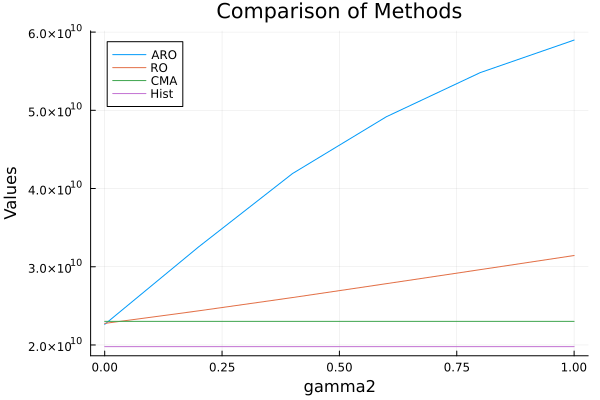

In [138]:
# Create the plot
plot(df.gamma2, [df.ARO, df.RO, df.CMA, df.Hist], 
    label=["ARO" "RO" "CMA" "Hist"], 
    xlabel="gamma2", ylabel="Values", 
    title="Comparison of Methods")

In [ ]:
#Q: how can I estimate gamma2 based on historical data? 


In [72]:
#compute the cumulative sum difference between actual loss and historical loss for the last 10 years 

# compute the cumulative sum of actual loss for the 10 years for all states 
act_sum = sum(act_loss, dims=2)
base_sum = sum(P_base, dims=2)
ro_sum= sum(P_ro, dims=2)
ml_sum = sum(P_ml, dims=2)
hist_sum = sum(P_hist, dims=2)
aro_sum = sum(P_aro, dims=2)

results = [act_sum[:]  hist_sum[:] base_sum[:] ro_sum[:] ml_sum[:]  aro_sum[:]]
# compute the sum 
sums = sum(results, dims=1)
results = [results; sums]
df = DataFrame(results ,:auto)
insertcols!(df,1, :states =>[state_list; "Total"])
new_column_names = [:state, :act, :hist, :base, :ro, :ml, :aro]
rename!(df, new_column_names)

Row,state,act,hist,base,ro,ml,aro
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,MD,5.1197e7,1.18408e6,5.53121e7,1.14608e8,1.14635e8,1.59782e8
2,MT,2.02623e6,127606.0,2.33075e6,4.24827e6,1.13612e7,6.0409e6
3,TX,9.27706e9,2.57303e7,2.01326e9,1.86899e9,1.86899e9,1.9937e10
4,FL,1.93123e9,4.79668e7,8.89122e8,1.24257e9,1.24258e9,4.13088e9
5,SC,4.5428e8,2.29803e6,1.45419e8,2.27704e8,2.2773e8,1.55103e9
6,VA,1.26343e8,5.0282e6,1.33837e8,2.20594e8,2.2062e8,3.88278e8
7,MI,8.98482e7,978104.0,1.68331e7,1.38318e7,2.3996e7,7.06477e7
8,NC,8.94274e8,7.6075e6,2.80464e8,3.35031e8,3.35051e8,1.55552e9
9,NJ,4.60996e8,3.89165e6,1.18701e9,2.81881e9,2.81881e9,1.69147e9


In [73]:
#compute surplus 
results2 = [act_sum[:]  hist_sum[:]-act_sum[:]  base_sum[:]-act_sum[:] ro_sum[:]-act_sum[:] ml_sum[:]-act_sum[:]  aro_sum[:]-act_sum[:]]
# compute the sum 
sums = sum(results2, dims=1)
results2 = [results2; sums]
df = DataFrame(results2 ,:auto)
insertcols!(df,1, :states =>[state_list; "Total"])
sort!(df, [:"x1"], rev=true)
new_column_names = [:state, :act, :hist, :base, :ro, :ml, :aro]
rename!(df, new_column_names)

Row,state,act,hist,base,ro,ml,aro
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,Total,1.9912e10,-1.97451e10,-8.3059e9,1.80477e9,2.02008e9,3.09696e10
2,TX,9.27706e9,-9.25133e9,-7.2638e9,-7.40806e9,-7.40806e9,1.06599e10
3,LA,3.79003e9,-3.77531e9,-3.66873e8,4.0188e9,4.01879e9,9.10661e9
4,FL,1.93123e9,-1.88326e9,-1.04211e9,-6.88657e8,-6.88647e8,2.19965e9
5,NC,8.94274e8,-8.86667e8,-6.1381e8,-5.59244e8,-5.59223e8,6.61249e8
6,NJ,4.60996e8,-4.57105e8,7.26014e8,2.35781e9,2.35781e9,1.23048e9
7,SC,4.5428e8,-4.51982e8,-3.08861e8,-2.26577e8,-2.26551e8,1.09675e9
8,PA,2.74175e8,-2.68864e8,-5.16526e7,9.94285e7,9.94494e7,2.30392e8
9,NY,2.49379e8,-2.4057e8,8.63445e8,2.49943e9,2.49943e9,1.29822e9


In [476]:
sum(P_base) - sum(act_loss)

-8.305897219413555e9

In [494]:
#varying gamma2 

gamma2_ls = range(start=0, step =0.1, stop=2) 
surplus_ls = Array{Float64}(undef,length(gamma2_ls));

i=1 
for gamma2 in gamma2_ls
    P_ro = solve_ro3(gamma2, 1/maximum(P_hist)); 
    s = sum(P_ro)-sum(act_loss)
    surplus_ls[i] = s 
    i+=1 
end  


L_star3.391861401928947e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 3.39e+09 1.45e+00   0.0 0.00e+00

L_star3.94398018163546e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 3.94e+09 1.45e+00   0.0 0.00e+00 

L_star4.496098961341972e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 4.50e+09 1.45e+00   0.0 0.00e+00

L_star5.048217741048486e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 5.05e+09 1.45e+00   0.0 0.00e+00

L_star5.600336520754999e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 5.60e+09 1.45e+00   0.0 0.00e+00

L_star6.152455300461512e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 6.15e+09 1.45e+00   0.0 0.00e+00

L_star6.704574080168024e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 6.70e+09 1.45e+00   0.0 0.00e+00

┌ Warning: Function f_piecewise_linear automatically registered with 2 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :f_piecewise_linear, 2, f_piecewise_linear; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/vwZYM/src/Nonlinear/operators.jl:370
┌ Warning: Function f_piecewise_linear automatically registered with 2 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :f_piecewise_linear, 2, f_piecewise_linear; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/vwZYM/src/Nonlinear/operators.j

LoadError: InterruptException:

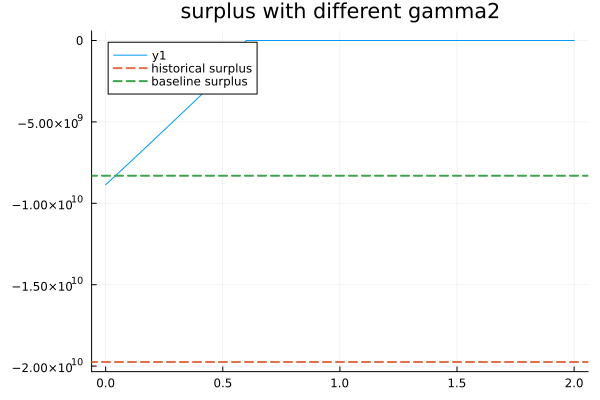

In [495]:
#plot different gamma2 leading to different surplus 
# DataFrame(hcat(gamma2_ls, surplus_ls), [:"Gamma2",:"Surplus"]); 
plot(gamma2_ls , surplus_ls, title="surplus with different gamma2")

#compute cumulative loss of Premium - loss for the last 10 years 
s_base = sum(P_base)-sum(act_loss)
s_hist = sum(P_hist)-sum(act_loss)
hline!([s_hist], line=(2, :dash), label="historical surplus")
hline!([s_base], line=(2, :dash), label="baseline surplus")

In [437]:
#iterate over different gamma2 
gamma2_ls = range(start=0, step =0.1 , stop=1.5) 
# slope_ls = [2*1/maximum(P_hist), 1/maximum(P_hist), 0.5*1/maximum(P_hist), 0.1*1/maximum(P_hist)]
# slope_ls = [ 1/maximum(P_hist), 0.01*1/maximum(P_hist), 0.0001*1/maximum(P_hist)]
slope_ls = [ 1/maximum(P_hist)]

#record different surplus associated with different slopes in a dictionary 
d = Dict() 

j =1 
for slope in slope_ls
    println("slope" , slope)
    i=1
    surplus_ls = Array{Float64}(undef,length(gamma2_ls));
    for gamma2 in gamma2_ls
        P_ro = solve_ro3(gamma2, slope); 
        s = sum(P_ro)-sum(act_loss)
        surplus_ls[i] = s 
        i+=1 
    end  
    d[j] = surplus_ls
    j+=1 
end 


slope2.1782772e-7
L_star3.391861401928947e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 3.39e+09 1.45e

L_star3.94398018163546e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 3.94e+09 1.45e+00   0.0 0.00e+00 

L_star4.496098961341972e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 4.50e+09 1.45e+00   0.0 0.00e+00

L_star5.048217741048486e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 5.05e+09 1.45e+00   0.0 0.00e+00

L_star5.600336520754999e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 5.60e+09 1.45e+00   0.0 0.00e+00

L_star6.152455300461512e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 6.15e+09 1.45e+00   0.0 0.00e+00

L_star6.704574080168024e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 6.70e+09 1.45e+00   0.0 0.00e+00

 725r 1.0121646e+03 1.22e+09 8.52e+03  -0.5 3.27e+09    -L_star7.256692859874537e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

L_star7.808811639581051e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 7.81e+09 1.45e+00   0.0 0.00e+00

L_star8.360930419287563e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 8.36e+09 1.45e+00   0.0 0.00e+00

L_star8.913049198994076e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 8.91e+09 1.45e+00   0.0 0.00e+00

L_star9.46516797870059e9
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4081
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      531
                     variables with only lower bounds:      531
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1219
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      954

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+03 9.47e+09 1.45e+00   0.0 0.00e+00 

Excessive output truncated after 576323 bytes.

┌ Warning: Function f_piecewise_linear automatically registered with 2 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :f_piecewise_linear, 2, f_piecewise_linear; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/vwZYM/src/Nonlinear/operators.jl:370
┌ Warning: Function f_piecewise_linear automatically registered with 2 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :f_piecewise_linear, 2, f_piecewise_linear; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/vwZYM/src/Nonlinear/operators.j

In [438]:
#add no demand damping 
i=1
surplus_ls = Array{Float64}(undef,length(gamma2_ls));
for gamma2 in gamma2_ls
    P_ro = solve_ro(gamma2); 
    s = sum(P_ro)-sum(act_loss)
    surplus_ls[i] = s 
    i+=1 
end 
d[0] = surplus_ls; 

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1007 rows, 531 columns and 2491 nonzeros
Model fingerprint: 0xdea90d15
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+03, 1e+03]
  RHS range        [5e+04, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 477 rows and 1 columns
Presolve time: 0.00s
Presolved: 530 rows, 1007 columns, 1961 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.064422e+10   0.000000e+00      0s
     525    1.0644216e+10   0.000000e+00   0.000000e+00      0s

Solved in 525 iterations and 0.00 seconds
Optimal objective  1.064421624e+10

User-callback calls 556, time in user-callback 0.00 sec
Ac

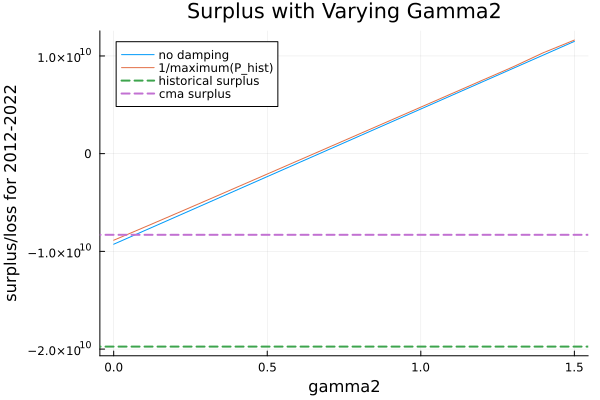

In [443]:
#plot different gamma2 leading to different surplus 
# plot(gamma2_ls, [d[0], d[1],d[2], d[3]], 
#         title="Surplus with Varying Gamma2", 
#         labels = ["no damping" "1/maximum(P_hist)" "0.1*1/maximum(P_hist)" "0.01*1/maximum(P_hist)" ],
#         xlabel = "gamma2", ylabel="surplus/loss for 2012-2022")

plot(gamma2_ls, [d[0], d[1]], 
        title="Surplus with Varying Gamma2", 
        labels = ["no damping" "1/maximum(P_hist)" ],
        xlabel = "gamma2", ylabel="surplus/loss for 2012-2022")


#compute cumulative loss of Premium - loss for the last 10 years 
s_base = sum(P_base)-sum(act_loss)
s_hist = sum(P_hist)-sum(act_loss)
hline!([s_hist], line=(2, :dash), label="historical surplus")
hline!([s_base], line=(2, :dash), label="cma surplus")

# savefig("figs/vary_gamma2.png")

In [444]:
#observe when does breakeven happen: between gamma2 in 0.6 and 0.7
[gamma2_ls d[1]]

16×2 Matrix{Float64}:
 0.0  -8.85965e9
 0.1  -7.52545e9
 0.2  -6.17563e9
 0.3  -4.81822e9
 0.4  -3.44985e9
 0.5  -2.08344e9
 0.6  -7.16028e8
 0.7   6.51576e8
 0.8   2.02008e9
 0.9   3.39222e9
 1.0   4.76261e9
 1.1   6.13377e9
 1.2   7.51017e9
 1.3   8.87835e9
 1.4   1.03452e10
 1.5   1.16249e10

In [49]:
x = time_list[end-9:end] 

for i in [1,2,3]
    print(state_list[i])

    #crop P_hist to the last 10 years only 
    P_hist2 = P_hist[:, end-9:end]
    
    act = cumsum(act_loss[i,:])
    base = cumsum(P_base[i,:])
    RO= cumsum(P_ro[i,:])
    ML = cumsum(P_ml[i,:])
    hist = cumsum(P_hist2[i,:])
    print(hist)
    plot(x, [act,  base, RO, hist, ML], label=["actual loss" "base" "RO" "hist" "ML"], title="state $(state_list[i])")

end 
    # savefig("figs/0.8gamma_la.png")

MDFloat32[57459.0, 122095.0, 207386.0, 297180.0, 419426.0, 567800.0, 739066.0, 874040.0, 978665.0, 1.076008f6]MTFloat32[4928.0, 14898.0, 25717.0, 34717.0, 44610.0, 54251.0, 71442.0, 89142.0, 103123.0, 119560.0]TXFloat32[2.03525f6, 4.118306f6, 6.25699f6, 8.313496f6, 1.0350093f7, 1.2507408f7, 1.4775038f7, 1.6976776f7, 1.831064f7, 1.9793714f7]

In [138]:
#see the difference between the RO and ML:
#whichs states have the largest difference over all years 
diff = sum(P_ml - P_ro, dims=2)


53×1 Matrix{Float64}:
  -26923.336976358667
       5.923884582531635e6
  -23978.12027812004
  -96827.56891460717
    -598.5258092544973
    -859.2369050867856
       1.0063875794804381e7
   15011.495973680168
   -5512.570274233818
  -32920.9756388627
  -23037.207937847823
   16844.269387602806
   -5475.209865435958
       ⋮
       2.281296059818318e6
       3.827536249217606e6
  -77781.50932915579
       8.237171040051438e6
 -227858.77325953194
      -1.9425517376277067e6
      -3.3087838062121784e6
  -30327.921682880493
       1.569666641001517e7
 -278972.7720948515
      -2.179316756349412e6
       4.700078808889064e6

In [139]:
df = DataFrame(diff, :auto)  
insertcols!(df,1, :states =>state_list)

Row,states,x1
,String,Float64
1,MD,-26923.3
2,MT,5.92388e6
3,TX,-23978.1
4,FL,-96827.6
5,SC,-598.526
6,VA,-859.237
7,MI,1.00639e7
8,NC,15011.5
9,NJ,-5512.57


In [ ]:
#problem: no difference...?? 

## Solving ARO 




In [21]:
# gamma2 = 0.8 
# gamma1 = 50000 
# #for now let's solve it for one state i 

# i=1 
# #construct c1, c2 for the dual formulation 
# c1 = mean_hist .+ gamma2.*std_hist*sqrt(10) #c1 is a vector, where c1[i] is the ith state value 
# c2 = -mean_hist .+ gamma2.*std_hist*sqrt(10)

# # c1 = mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10) #c1 is a vector, where c1[i] is the ith state value 
# # c2 = -mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)

# model = Model(Gurobi.Optimizer)
# set_optimizer_attribute(model, "TimeLimit", 60)


# # VARIABLES: premium for the next 10 years 
# T1 = 10 
# @variable(model, alpha[1:N, 1:T1]);  #P_i,t is the premium at state i in time t 
# @variable(model, beta[1:N, 1:T1]);
# @variable(model, s1[1:N] >=0);
# @variable(model, s2[1:N] >=0);
# @variable(model, omega); 

# surplus = 1000 #this is delta 

# #Epigraph formulation of the objective value 
# @objective(model, Min, omega)

# @constraint(model, epigraph, 
# sum(alpha[i, t] for t = 1:T1, i=1:N) + sum(c1[i]*s1[i]+c2[i] *s2[i] for i=1:N)  <= omega ); 

# @constraint(model, meeting_surplus[1:N], 
# -sum(alpha[i, t] for t = 1:T1) + (c1[i]*s1[i]+c2[i]*s2[i]) <= -surplus ); 

# for t=1:T1
#         @constraint(model, [1:N], 
#             s1[i]-s2[i] >= (T1-t)*beta[i,t]);    
# end 

# for t = 2:T1 #looping from 2, to accommodate t-1 
#         @constraint(model,[1:N], 
#                     alpha[i,t] - alpha[i, t-1] + (c1[i]*s1[i]+c2[i]*s2[i]) <= gamma1);
#         @constraint(model, [1:N], 
#                     -(alpha[i,t] - alpha[i, t-1] + (c1[i]*s1[i]+c2[i]*s2[i])) <= gamma1); 
#         @constraint(model, [1:N], 
#             s1[i]-s2[i] >= beta[i,t-1]);  
# end 
     

# #Q: how do I handle the t=0 case? I need p0 



# optimize!(model)

# #Q: how do I recover P 



Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2015 rows, 1167 columns and 8057 nonzeros
Model fingerprint: 0x334b6340
Coefficient statistics:
  Matrix range     [1e+00, 5e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 5e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 955 rows and 1154 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model

User-callback calls 19, time in user-callback 0.00 sec


In [1]:
#Let's try solving for just one i: 
function solve_aro(i)     
    gamma2 = 0  
    gamma1 = 50000 
    T1= 10 
    #for now let's solve it for one state i 
    c1 = mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10) #c1 is a vector, where c1[i] is the ith state value 
    c2 = -mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)
    println(c1, c2)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 60)


    # VARIABLES: premium for the next 10 years 
    @variable(model, alpha[1:T1]>=0);  #P_i,t is the premium at state i in time t 
    @variable(model, beta[1:(T1-1)]>=0);
    @variable(model, s1>=0);
    @variable(model, s2>=0);
    @variable(model, omega); 

    surplus = 1000 #this is delta 

    #Epigraph formulation of the objective value 
    @objective(model, Min, omega)

    @constraint(model, epigraph, 
        sum(alpha[t] for t = 1:T1) + (c1*s1+c2*s2)  <= omega ); 
    
    for t=1:(T1-1)
        @constraint(model, 
            s1-s2 >= (T1-t)*beta[t]);  
    end 

    @constraint(model, meeting_surplus, 
        -sum(alpha[t] for t = 1:T1) + (c1*s1+c2*s2) <= -surplus ); 
    
    for t=1:(T1-1)
        @constraint(model, 
            s1-s2 >= 1-(T1-t)*beta[t]);  
    end 
    @constraint(model, s1-s2>= 1); 
 


    for t=2:T1 #looping from 2, to accommodate t-1 
            @constraint(model,
                alpha[t] - alpha[t-1] + (c1*s1+c2*s2) <= gamma1);
            @constraint(model, 
                -(alpha[t] - alpha[t-1] + (c1*s1+c2*s2)) <= gamma1); 
            @constraint(model, 
                s1-s2 >= beta[t-1]);  
    end 
    @constraint(model, s1-s2>=0); 

    for t=1:T1
        @constraint(model, 
            -alpha[t] - (c1*s1+c2*s2) <= 0); 
    end 

    for t=1:(T1-1)
        @constraint(model, 
            s1-s2 >= beta[t]); 
    end 
    @constraint(model, alpha[1]>=0)

    optimize!(model)
    return value.(alpha), value.(beta)
end 


LoadError: LoadError: UndefVarError: @variable not defined
in expression starting at In[1]:15

In [106]:
alpha, beta = solve_aro(1)
recover_P(i, alpha, beta)

6.366786112596649e75.234893327228227e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 22 columns and 240 nonzeros
Model fingerprint: 0xe1ff85f7
Coefficient statistics:
  Matrix range     [1e+00, 6e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 32 rows and 1 columns
Presolve time: 0.00s
Presolved: 37 rows, 30 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3667861e+07   4.854047e+03   0.000000e+00      0s
      10    2.9264716e+09   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds
Optimal objective  2.926471612e+09

User-callback calls 43, time in user-callback 0.00 sec


1×10 Matrix{Float64}:
 5.72561e8  5.08943e8  4.45325e8  …  1.27236e8  6.36179e7  1.96668e7

In [107]:
#how do I recover P, and l? 
function recover_P(i, alpha, beta)
    act_loss = M_amt[:,end-9:end];  
    T1 = 10 
    P_i = Matrix{Float64}(undef,1,T1); 
    P_i[1] = alpha[1]
    for t=2:T1
        P_i[t] = alpha[t] + sum(beta[t2] * act_loss[i, t2] for t2=1:t-1)
    end 
    return P_i 
end 

recover_P (generic function with 1 method)

In [108]:
T1= 10 
P_aro = Matrix{Float64}(undef,N,T1);  
for i=1:N 
    alpha_i, beta_i = solve_aro(i); 
    P_aro[i,:] = recover_P(i, alpha_i, beta_i); 
end 


6.366786112596649e75.234893327228227e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 22 columns and 240 nonzeros
Model fingerprint: 0xe1ff85f7
Coefficient statistics:
  Matrix range     [1e+00, 6e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 32 rows and 1 columns
Presolve time: 0.00s
Presolved: 37 rows, 30 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3667861e+07   4.854047e+03   0.000000e+00      0s
      10    2.9264716e+09   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds
Optimal objective  2.926471612e+09

User-callback calls 43, time in user-callback 0.00 sec
2.0780550897714165e61.6109301913503641e6
Academic license - for non-commercial use

5.1783819742426395e73.496382303295271e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 22 columns and 240 nonzeros
Model fingerprint: 0x8cefa61d
Coefficient statistics:
  Matrix range     [1e+00, 5e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 32 rows and 1 columns
Presolve time: 0.00s
Presolved: 37 rows, 30 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1783820e+07   3.947366e+03   0.000000e+00      0s
      10    2.3798057e+09   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds
Optimal objective  2.379805708e+09

User-callback calls 42, time in user-callback 0.00 sec
4.756136377844998e94.0777640974592085e9
Academic license - for non-commercial use

6.197681997328022e75.0674906933280215e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 22 columns and 240 nonzeros
Model fingerprint: 0xd8ff1dcd
Coefficient statistics:
  Matrix range     [1e+00, 6e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 32 rows and 1 columns
Presolve time: 0.00s
Presolved: 37 rows, 30 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1976820e+07   4.725031e+03   0.000000e+00      0s
      10    2.8486837e+09   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds
Optimal objective  2.848683719e+09

User-callback calls 43, time in user-callback 0.00 sec
995473.2759993176742147.5207361598
Academic license - for non-commercial use only

1.7338937317608114e71.1221568487081798e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 22 columns and 240 nonzeros
Model fingerprint: 0x852d7352
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 32 rows and 1 columns
Presolve time: 0.00s
Presolved: 37 rows, 30 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7338937e+07   2.638861e+03   0.000000e+00      0s
      10    7.9534112e+08   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds
Optimal objective  7.953411166e+08

User-callback calls 42, time in user-callback 0.00 sec
1.5059927462185288e71.1249253394816866e7
Academic license - for non-commercial u

2.5029065450995187e61.957150729836361e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 22 columns and 240 nonzeros
Model fingerprint: 0xffa4447b
Coefficient statistics:
  Matrix range     [1e+00, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 32 rows and 1 columns
Presolve time: 0.00s
Presolved: 37 rows, 30 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4556989e+07   2.395716e+03   0.000000e+00      0s
       9    1.1288370e+08   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective  1.128837011e+08

User-callback calls 41, time in user-callback 0.00 sec
6.9513810510113435e65.50564788522187e6
Academic license - for non-commercial use o

In [109]:
P_aro[1,:]

10-element Vector{Float64}:
 5.725607501336985e8
 5.089428890077319e8
 4.453250278817654e8
 3.8170716675579894e8
 3.1808930562983245e8
 2.5447144450386596e8
 1.9085358337789947e8
 1.2723572225193298e8
 6.361786112596649e7
 1.260457337e7

In [125]:
#check if actual loss lives in the CLT uncertainty set:
i=5 
gamma2= 0.8  

lower = - mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)
upper = mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)
sum_i = sum(act_loss[i,:])

if (lower <= sum_i) & (sum_i <= upper)
    println("lives in U")
elseif  (sum_i < lower) 
    println("less")
elseif (sum_i > upper)
    println("more")
end 

more


In [63]:
# gamma2 = 0.8 
# slope = 1/maximum(P_hist)
# P_ro = solve_ro2(gamma2, slope)
# P_ml = solve_ro3(gamma2, slope) #1/l_max 

FLFloat32[4.585367f6, 8.713942f6, 1.2693365f7, 1.6570976f7, 2.0581366f7, 2.4463612f7, 2.8577836f7, 3.2046528f7, 3.4200836f7, 3.616406f7]

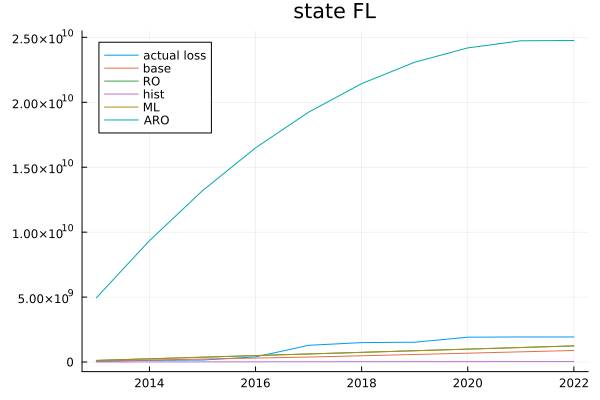

In [127]:
x = time_list[end-9:end] 

i=4 
print(state_list[i])

#crop P_hist to the last 10 years only 
P_hist2 = P_hist[:, end-9:end]

act = cumsum(act_loss[i,:])
base = cumsum(P_base[i,:])
RO= cumsum(P_ro[i,:])
ML = cumsum(P_ml[i,:])
hist = cumsum(P_hist2[i,:])
ARO = cumsum(P_aro[i,:])
print(hist)
plot(x, [act,  base, RO, hist, ML, ARO], label=["actual loss" "base" "RO" "hist" "ML" "ARO"], title="state $(state_list[i])")

In [130]:
sum(P_aro)- sum(act_loss)

5.281744881421229e11

In [3]:
#compare julia with python https://dataframes.juliadata.org/stable/man/comparisons/ 